# Shift Trancation

In [87]:
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.nn.norm import GraphNorm
from torch.nn import Linear, InstanceNorm2d
import random
import matplotlib.pyplot as plt
from torch_geometric.transforms import FaceToEdge
from torch_geometric.data import Data
from itertools import combinations

polygon.vertices: tensor([[0.6905, 0.2678],
        [0.2500, 0.2000],
        [0.7500, 0.1000],
        [1.3000, 0.4330],
        [0.7500, 0.8660],
        [0.2500, 0.8660],
        [0.1500, 0.4330]]) polygon.faces: tensor([[1, 2, 0],
        [2, 3, 0],
        [3, 4, 0],
        [4, 5, 0],
        [5, 6, 0],
        [6, 1, 0]]) polygon.edge_index: tensor([[1, 4, 3, 6, 2, 3, 2, 4, 5, 5, 6, 1],
        [2, 0, 4, 1, 0, 0, 3, 5, 0, 6, 0, 0]]) polygon.num_features: 2


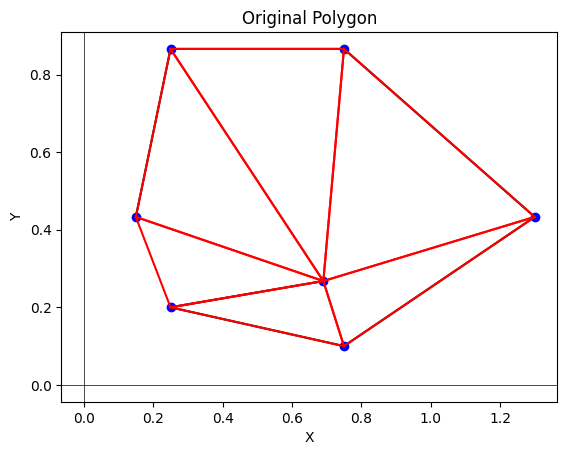

In [88]:
def create_data():
    random_number_x = random.random()
    random_number_y = random.random()
    root_3 = torch.sqrt(torch.tensor(3.))
    vertices = torch.tensor([[random_number_x, random_number_y], [0.25, 0.2], [0.75, 0.1], [1.3, 0.25*root_3], [0.75, 0.5*root_3], [0.25, 0.5*root_3], [0.15, 0.25*root_3]], dtype=torch.float32)
    faces = torch.tensor([[1, 2, 0], [2, 3, 0], [3, 4, 0], [4, 5, 0], [5, 6, 0], [6, 1, 0]])
    # エッジ情報を三角形の麺情報から抽出
    edges = []
    for face in faces:
        # 三角形の拡張店のペアを取得してエッジとして追加
        edges.extend(combinations(face.tolist(),2))
    
    # 重複するエッジを削除し、エッジのリストを作成
    edges = list(set(edges))

    polygon = Data(x=vertices, edge_index=torch.tensor(edges).t().contiguous(), faces=faces)
    polygon.num_features = len(polygon.x[0])
    # print(polygon)
    return polygon

def plot_mesh(vertices, faces, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # 描画するメッシュの頂点をプロット
    ax.plot(vertices[:,0], vertices[:,1], 'bo')  # 頂点を青色の点でプロット
    ax.plot(vertices[:,0], vertices[:,1], 'k-')  # 辺を黒色の線でプロット

    # 各三角形をプロット
    for face in faces:
        v0, v1, v2 = vertices[face]
        ax.plot([v0[0], v1[0], v2[0], v0[0]], [v0[1], v1[1], v2[1], v0[1]], 'r-')  # 三角形を赤色の線でプロット

    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.axhline(0, color="black", linewidth=0.5)
    ax.axvline(0, color="black", linewidth=0.5)

    plt.show()

polygon = create_data()
print("polygon.vertices:", polygon.x,
      "polygon.faces:",polygon.faces,
      "polygon.edge_index:",polygon.edge_index,
      "polygon.num_features:", polygon.num_features)
# オリジナルのメッシュをプロット
plot_mesh(polygon.x, polygon.faces, title="Original Polygon")

Normalized polygon: tensor([[ 0.0000,  0.0000],
        [-0.3831, -0.0589],
        [ 0.0517, -0.1459],
        [ 0.5300,  0.1437],
        [ 0.0517,  0.5202],
        [-0.3831,  0.5202],
        [-0.4700,  0.1437]])


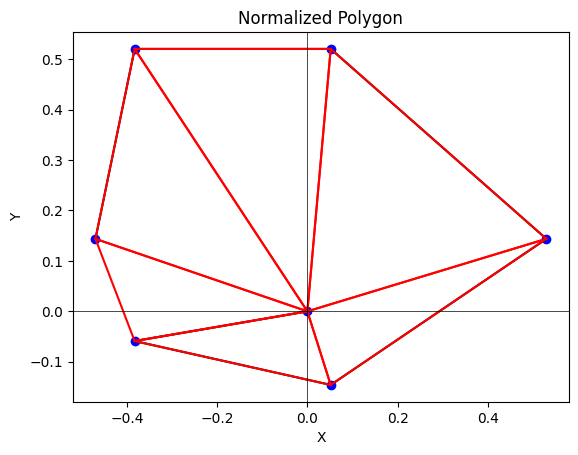

In [89]:
def normalization(vertices):
    d = torch.max(torch.max(vertices[:,0])-torch.min(vertices[:,0]), torch.max(vertices[:,1])-torch.min(vertices[:,1]))
    x_min = torch.min(vertices[:,0])
    y_min = torch.min(vertices[:,1])
    for i in range(len(vertices[:,0])):
        vertices[i-1,0] = (vertices[i-1,0]-x_min) / d
        vertices[i-1,1] = (vertices[i-1,1]-y_min) / d
    
    Cx = vertices[0,0].item()
    Cy = vertices[0,1].item()   

    for i in range(len(vertices[:,0])):
        vertices[i-1,0] = vertices[i-1,0]-Cx
        vertices[i-1,1] = vertices[i-1,1]-Cy
    
    print("Normalized polygon:", vertices)

    return vertices, d, Cx, Cy, x_min, y_min

polygon.x, polygon.d, polygon.Cx, polygon.Cy, polygon.x_min, polygon.y_min = normalization(polygon.x)
plot_mesh(polygon.x, polygon.faces, title="Normalized Polygon")

    


shift: 0.2508134532255333 , -0.43776475060571707


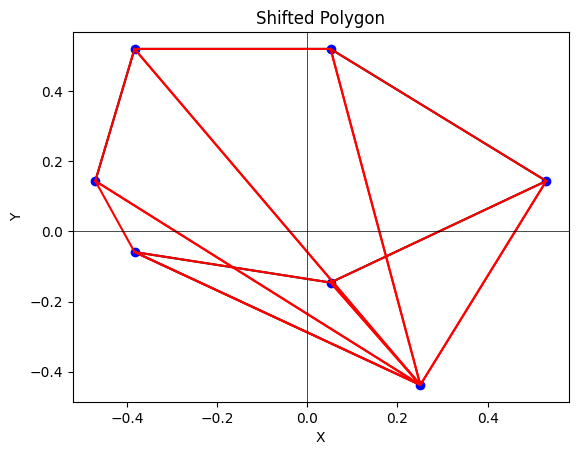

tensor([[ 0.2508, -0.4378],
        [-0.3831, -0.0589],
        [ 0.0517, -0.1459],
        [ 0.5300,  0.1437],
        [ 0.0517,  0.5202],
        [-0.3831,  0.5202],
        [-0.4700,  0.1437]])


In [90]:


random_shift_x = random.random() - 0.5
random_shift_y = random.random() - 0.5
print("shift:", random_shift_x,",", random_shift_y)
polygon.x[0,0] = polygon.x[0,0] + random_shift_x
polygon.x[0,1] = polygon.x[0,1] + random_shift_y
plot_mesh(polygon.x, polygon.faces, title="Shifted Polygon")
print(polygon.x)


# スターポリゴンから出たかどうかの判定をする関数

In [91]:
print(polygon.x[1])
print(polygon.x[1][0])
print(polygon.x[1][1])

tensor([-0.3831, -0.0589])
tensor(-0.3831)
tensor(-0.0589)


6
range(1, 7)


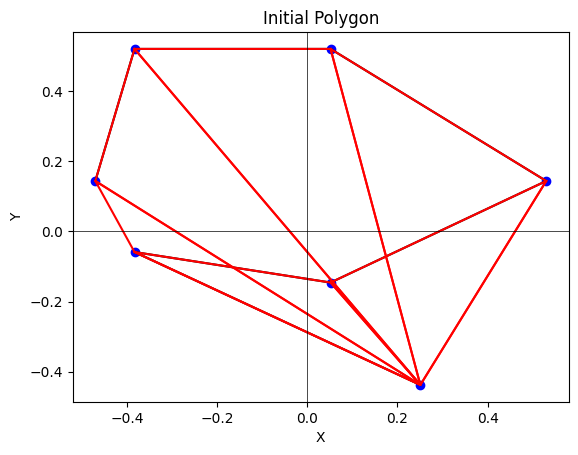

In [92]:
print(len(polygon.x[:,0])-1)
print(range(1, len(polygon.x[:,0])))
plot_mesh(polygon.x, polygon.faces, title="Initial Polygon")

tensor([ 0.0517, -0.1459])
1: tensor(0.7275) 2: tensor(0.0556) 3: tensor(-0.1355) 4: tensor(0.2521)
tensor([0.5300, 0.1437])
1: tensor(0.0556) 2: tensor(-1.0687) 3: tensor(-0.1772) 4: tensor(0.4124)
Out_of_StarPolygon


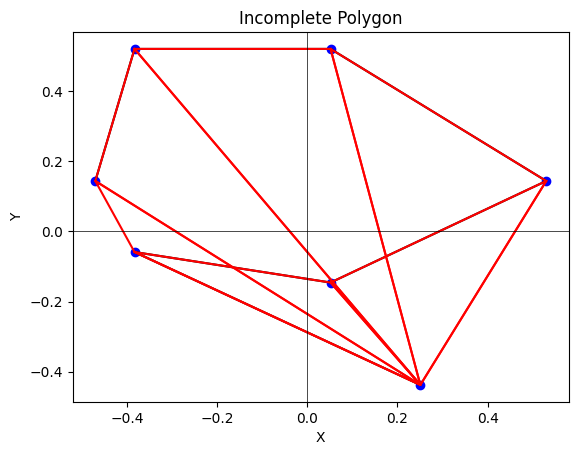

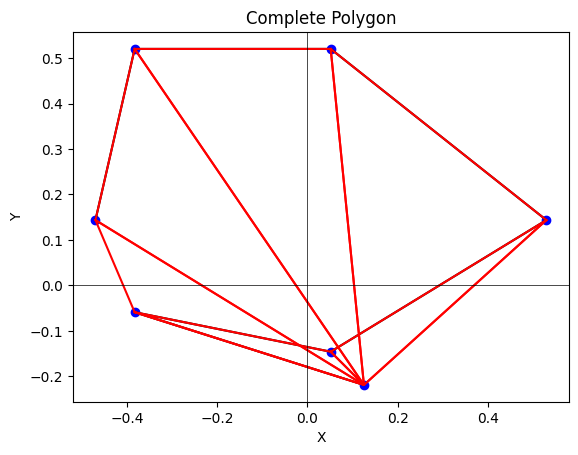

tensor([ 0.0517, -0.1459])
1: tensor(0.7275) 2: tensor(0.0556) 3: tensor(-0.1355) 4: tensor(0.0583)
tensor([0.5300, 0.1437])
1: tensor(0.0556) 2: tensor(-1.0687) 3: tensor(-0.1772) 4: tensor(0.1176)
Out_of_StarPolygon


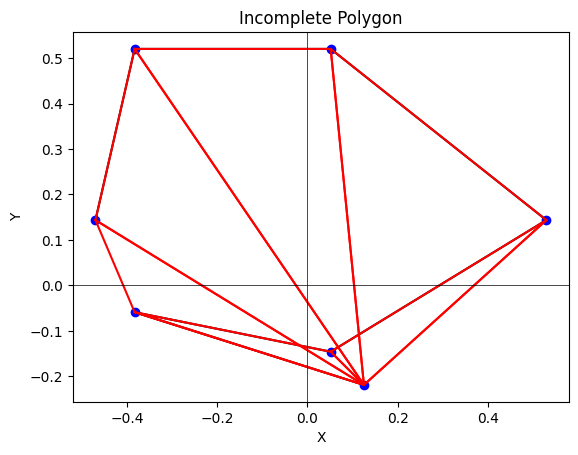

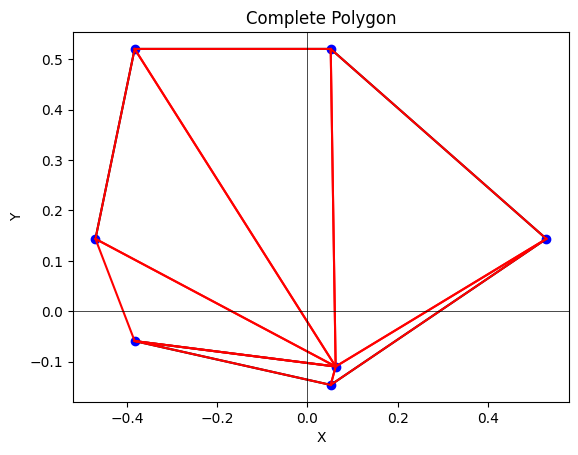

tensor([ 0.0517, -0.1459])
1: tensor(0.7275) 2: tensor(0.0556) 3: tensor(-0.1355) 4: tensor(-0.0386)
tensor([0.5300, 0.1437])
1: tensor(0.0556) 2: tensor(-1.0687) 3: tensor(-0.1772) 4: tensor(-0.0298)
tensor([0.0517, 0.5202])
1: tensor(-1.0687) 2: tensor(-0.6105) 3: tensor(0.5610) 4: tensor(0.6210)
tensor([-0.3831,  0.5202])
1: tensor(-0.6105) 2: tensor(0.1484) 3: tensor(0.5202) 4: tensor(0.6297)
tensor([-0.4700,  0.1437])
1: tensor(0.1484) 2: tensor(0.6767) 3: tensor(2.1789) 4: tensor(2.5599)
tensor([-0.3831, -0.0589])
1: tensor(0.6767) 2: tensor(0.7275) 3: tensor(-0.9515) 4: tensor(-0.9882)


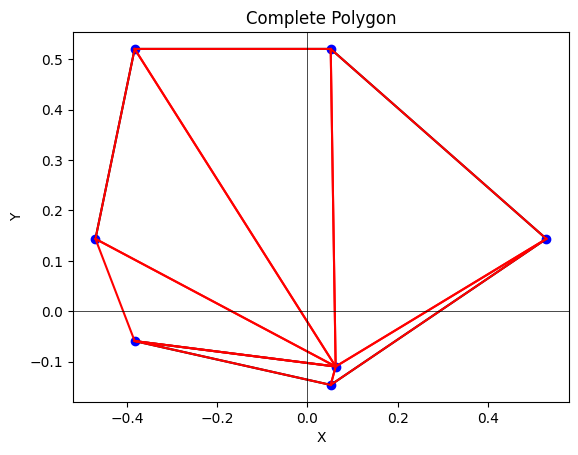

tensor([[ 0.0627, -0.1094],
        [-0.3831, -0.0589],
        [ 0.0517, -0.1459],
        [ 0.5300,  0.1437],
        [ 0.0517,  0.5202],
        [-0.3831,  0.5202],
        [-0.4700,  0.1437]])


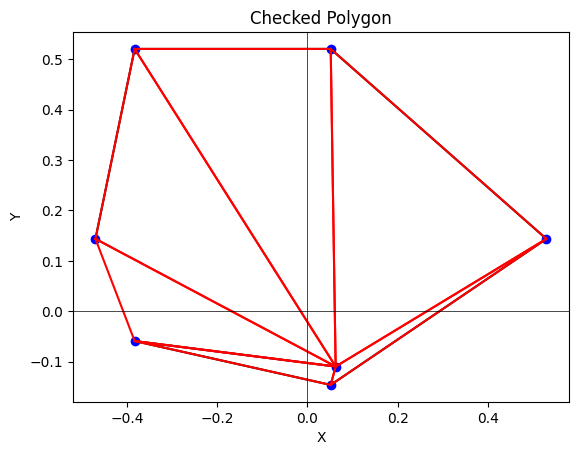

In [93]:
def check(polygon, polygonID):
    print("polygonID:", polygonID)
    vertices = polygon.coordinates
    return_value = True
    while return_value == True:   

        for i in range(1, len(vertices[:,0])):
            point1 = torch.tensor([0.0, 0.0])
            point2 = vertices[0]
            point3 = vertices[i]
            if i+1 == len(vertices[:,0]):
                point4 = vertices[1]
            else :
                 point4 = vertices[i+1]
            # print(point4)


            a1 = 0
            b1 = 0
            a2 = 0
            b2 = 0
            check1 = 0
            check2 = 0
            check3 = 0
            check4 = 0
            a1 = (point1[1] - point2[1])/(point1[0]-point2[0])
            b1 = point1[1] - (a1*point1[0])
            a2 = (point3[1] - point4[1])/(point3[0]-point4[0])
            b2 = point3[1] - (a2*point3[0])
            check1 = (a1*point3[0]) - point3[1] + b1 
            check2 = (a1*point4[0]) - point4[1] + b1    # point1,2を通る直線に対してpoint3,4を結ぶ線分が交差しているか
            check3 = (a2*point1[0]) - point1[1] + b2
            check4 = (a2*point2[0]) - point2[1] + b2    # point3,4を通る直線に対してpoint1,2を結ぶ線分が交差しているか
            # print("1:",check1,"2:",check2,"3:",check3,"4:",check4)

            if (check1*check2) < 0 and (check3*check4) <0 :
                return_value = True
                print("Out_of_StarPolygon")
                vertices[0] = 0.5*vertices[0]
                polygon.coordinates[0] = vertices[0]
                break
            else:
                return_value = False
                continue       
            
        
    # plot_mesh(polygon, "polygon_checked")
               
    return polygon
